### 环境初始化

In [1]:
# 在jupyter notebook里env.render看不到窗口
# 写一个helper类，用matplotlib刷新显示图像
# 初始化传入env，调用helper的render即可
from IPython import display # 导入display模块，用于在Jupyter Notebook中显示图像
import matplotlib
import matplotlib.pyplot as plt # 导入matplotlib库，用于绘制图像
%matplotlib inline

class GymHelper:
    def __init__(self, env, figsize = (3, 3)):
        self.env = env # 初始化Gym环境
        self.figsize = figsize # 初始化绘图窗口大小
        
        plt.figure(figsize = figsize) # 创建绘图窗口
        plt.title(self.env.spec.id) # 标题设为环境名
        self.img = plt.imshow(env.render()) # 在绘图窗口中显示初始图像
    
    def render(self, title = None):
        image_data = self.env.render() # 获取当前环境图像渲染数据
        
        self.img.set_data(image_data) # 更新绘图窗口中的图像数据
        display.display(plt.gcf()) # 刷新显示
        display.clear_output(wait = True) # 有新图片时再清除绘图窗口原有图像
        if title: # 如果有标题，就显示标题
            plt.title(title)

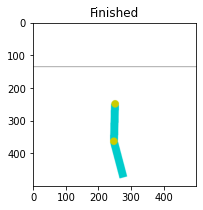

In [2]:
# 导入gym库
import gym

# 创建环境，指定渲染模式为rgb_array，如果是在IDE中可以改为'human'
env = gym.make('Acrobot-v1', render_mode='rgb_array')
# 重置环境
env.reset()
# 创建GymHelper
gym_helper = GymHelper(env)

# 循环N次
for i in range(20):
    gym_helper.render(title = str(i)) # 渲染环境
    action = env.action_space.sample() # 从动作空间中随机选取一个动作
    observation, reward, terminated, truncated, info = env.step(action) # 执行动作
    if terminated or truncated: # 如果游戏结束，则结束循环
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()

### SAC

In [3]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import sys
import time
import random
import collections
from tqdm import * # 用于显示进度条

# 策略模型，给定状态生成各个动作的概率
class PolicyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyModel, self).__init__()
        
        # 使用全连接层构建一个简单的神经网络，ReLU作为激活函数
        # 最后加一个Softmax层，使得输出可以看作是概率分布
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim = 1)
        )

    # 定义前向传播，输出动作概率分布
    def forward(self, x):
        action_prob = self.fc(x)
        return action_prob

# Q网络模型，给定状态和动作样本对估计Q值
class QValueModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QValueModel, self).__init__()
        
        # 网络结构和策略模型类似，输出维度为动作空间的维度
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    # 定义前向传播，输出Q值估计
    def forward(self, x):
        value = self.fc(x)
        return value

In [4]:
# 经验回放缓冲区
class ReplayBuffer:
    # 构造函数，max_size是缓冲区的最大容量
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = collections.deque(maxlen = self.max_size)  # 用collections的队列存储，先进先出

    # 添加experience（五元组）到缓冲区
    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    # 取出buffer中的所有数据
    def return_all(self):
        batch = list(self.buffer)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

    # 从buffer中随机采样，数量为batch_size
    def sample(self, batch_size):
        if batch_size > len(self.buffer):
            return self.return_all()
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)
    
    # 返回缓冲区数据数量
    def __len__(self):
        return len(self.buffer)

In [5]:
# SAC算法
class SAC:
    # 构造函数，参数包含环境，学习率，折扣因子，更新目标网络参数
    def __init__(self, env, learning_rate=0.001, gamma=0.99, rho=0.01):
        self.env = env
        self.gamma = gamma
        self.rho = rho
#         self.replay_buffer = ReplayBuffer(max_size=buffer_size)
        
        # 设置一个较大的目标熵值，取负值转为最小化问题
        self.target_entropy = -np.log2(env.action_space.n)
        
        # 判断可用的设备是 CPU 还是 GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # 创建模型，并将模型移动到指定设备上
        # 包括策略网络、两个Q值网络和它们对应的目标网络
        self.actor = PolicyModel(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.q1 = QValueModel(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.q2 = QValueModel(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.target_q1 = QValueModel(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.target_q2 = QValueModel(env.observation_space.shape[0], env.action_space.n).to(self.device)
        
        # 将Q值网络的参数复制到对应的目标网络中，以确保初始的Q值网络和目标网络参数相同
        for param, target_param in zip(self.q1.parameters(), self.target_q1.parameters()):
            target_param.data.copy_(param)
        for param, target_param in zip(self.q2.parameters(), self.target_q2.parameters()):
            target_param.data.copy_(param)
        
        # 定义Adam优化器
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=learning_rate)
        self.optimizer_q1 = torch.optim.Adam(self.q1.parameters(), lr=learning_rate)
        self.optimizer_q2 = torch.optim.Adam(self.q2.parameters(), lr=learning_rate)
        
        # alpha作为可学习参数，学习其对数值可确保alpha=exp(log_alpha)>0
        self.log_alpha = torch.tensor([0.0], device=self.device, requires_grad=True)
        self.optimizer_log_alpha = torch.optim.Adam([self.log_alpha], lr=learning_rate)

    # 使用模型生成动作概率分布并采样
    def choose_action(self, state):
        # 将状态转换为tensor输入模型
        state = torch.FloatTensor(np.array([state])).to(self.device)
        with torch.no_grad():
            action_prob = self.actor(state)
        
        # 生成分布后采样返回动作
        c = torch.distributions.Categorical(action_prob)
        action = c.sample()
        return action.item()
    
    # 模型更新
    def update(self, buffer):
        # 取出数据，并将其转换为numpy数组
        # 然后进一步转换为tensor，并将数据转移到指定计算资源设备上
        states, actions, rewards, next_states, dones = buffer
#         states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.tensor(np.array(actions)).view(-1, 1).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards)).view(-1, 1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(np.array(dones)).view(-1, 1).to(self.device)
        
        ##### Q网络更新 #####
        # 计算下一个状态的动作概率和对数
        next_action_prob = self.actor(next_states)
        log_next_prob = torch.log(next_action_prob + 1e-9) # 避免对零取对数
        
        # 计算目标Q值
        target_q1 = self.target_q1(next_states)
        target_q2 = self.target_q2(next_states)
        target_q_min = torch.min(target_q1, target_q2)
        min_q_next_target = next_action_prob * (target_q_min - torch.exp(self.log_alpha) * log_next_prob)
        min_q_next_target = torch.sum(min_q_next_target, dim = 1, keepdim = True)
        
        # 计算TD目标
        td_target = rewards + (1 - dones) * self.gamma * min_q_next_target
        
        # 计算Q网络的loss
        q1 = self.q1(states)
        q2 = self.q2(states)
        q1_loss = F.mse_loss(q1.gather(1, actions), td_target.detach()).mean()
        q2_loss = F.mse_loss(q2.gather(1, actions), td_target.detach()).mean()
        
        # 梯度清零、反向传播、更新参数
        self.optimizer_q1.zero_grad()
        self.optimizer_q2.zero_grad()
        q1_loss.backward()
        q2_loss.backward()
        self.optimizer_q1.step()
        self.optimizer_q2.step()
        
        ##### actor网络更新 #####
        # 计算当前状态的动作概率
        action_prob = self.actor(states)
        log_prob = torch.log(action_prob + 1e-9)
        
        # 计算Q值和actor网络的loss
        q1 = self.q1(states)
        q2 = self.q2(states)
        inside_term = torch.exp(self.log_alpha) * log_prob - torch.min(q1, q2)
        actor_loss = torch.sum(action_prob * inside_term, dim = 1, keepdim = True).mean()
        
        # 梯度清零、反向传播、更新参数
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()
        
        ##### alpha参数更新 #####
        # 计算alpha值的loss
        inside_term = -torch.sum(action_prob * log_prob, dim = 1, keepdim = True) - self.target_entropy
        alpha_loss = (torch.exp(self.log_alpha) * inside_term.detach()).mean()
        # 梯度清零、反向传播、更新参数
        self.optimizer_log_alpha.zero_grad()
        alpha_loss.backward()
        self.optimizer_log_alpha.step()
        
        ##### target网络更新 #####
        for param, target_param in zip(self.q1.parameters(), self.target_q1.parameters()):
            target_param.data.copy_(param.data * self.rho + target_param.data * (1 - self.rho))
        for param, target_param in zip(self.q2.parameters(), self.target_q2.parameters()):
            target_param.data.copy_(param.data * self.rho + target_param.data * (1 - self.rho))

### MBPO

In [6]:
# 定义计算设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义一个用于构造集成模型的全连接类
class EnsembleFC(nn.Module):
    def __init__(self, input_dim, output_dim, ensemble_size):
        super(EnsembleFC, self).__init__()
        
        # 定义输入维度、输出维度和集成模型的数量
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.ensemble_size = ensemble_size
        
        # 初始化权重矩阵和偏置向量。为每个集成模型都初始化一个权重矩阵和一个偏置向量。
        # 权重矩阵的大小是 (ensemble_size, input_dim, output_dim)
        # 偏置向量的大小是 (ensemble_size, 1, output_dim)
        # nn.Parameter可以自动被添加到模型的参数列表中，使得在优化时可以被自动更新
        self.weight = nn.Parameter(torch.Tensor(ensemble_size, input_dim, output_dim).to(device))
        self.bias = nn.Parameter(torch.Tensor(ensemble_size, output_dim).to(device))

    # 定义前向传播
    def forward(self, x):
        # 使用矩阵乘法将输入x和权重矩阵相乘
        w_times_x = torch.bmm(x, self.weight)
        # 将矩阵乘法的结果与偏置向量（需匹配维度）相加，得到最终的输出
        return torch.add(w_times_x, self.bias[:, None, :])

In [7]:
# 定义一个集成模型类
class EnsembleModel(nn.Module):
    # 构造函数，参数包含状态空间维度、动作空间维度、模型个数、奖励维度、隐藏层大小、学习率
    def __init__(self, state_size, action_size, ensemble_size, reward_size=1, hidden_size=128, learning_rate=0.001):
        super(EnsembleModel, self).__init__()
        
        # 定义隐藏层大小、输入维度、输出维度、运算设备
        self.hidden_size = hidden_size
        self.input_dim = state_size + action_size
        self.output_dim = state_size + reward_size
        self.device = device
        
        # 使用EnsembleFC分别创建4个全连接层
        # 最后的输出为均值和方差，所以是预期输出维度乘以2
        self.nn1 = EnsembleFC(self.input_dim, hidden_size, ensemble_size)
        self.nn2 = EnsembleFC(hidden_size, hidden_size * 2, ensemble_size)
        self.nn3 = EnsembleFC(hidden_size * 2, hidden_size, ensemble_size)
        self.nn4 = EnsembleFC(hidden_size, self.output_dim * 2, ensemble_size)
        
        # 初始化log方差的最大最小值
        self.max_logvar = nn.Parameter((torch.ones((1, self.output_dim)).float() / 2).to(self.device), requires_grad=False)
        self.min_logvar = nn.Parameter((torch.zeros((1, self.output_dim)).float()).to(self.device), requires_grad=False)
        
        # 定义Adam优化器
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        # 定义初始化权重的方法，并对模型的所有权重进行初始化
        def init_weights(m):
            if type(m) == nn.Linear or isinstance(m, EnsembleFC):
                torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                torch.nn.init.constant_(m.bias, 0)
        self.apply(init_weights)
    
    # 定义前向传播
    def forward(self, x, ret_log_var=False):
        # 通过全连接网络进行特征提取和处理，激活函数使用ReLU函数
        x = torch.relu(self.nn1(x))
        x = torch.relu(self.nn2(x))
        x = torch.relu(self.nn3(x))
        x = self.nn4(x)
        
        # 计算预测的均值
        mean = x[:, :, :self.output_dim]

        # 计算预测的log方差，并通过softplus函数进行变换保证log方差能平滑的落在最大最小值之间
        logvar = self.max_logvar - F.softplus(self.max_logvar - x[:, :, self.output_dim:]) # 映射到(-inf, max]
        logvar = self.min_logvar + F.softplus(logvar - self.min_logvar) # 映射到[min, max]
        
        # 根据标志参数返回不同的结果，差异在于返回方差的对数还是原始值
        if ret_log_var:
            return mean, logvar
        else:
            return mean, torch.exp(logvar)
    
    # 定义损失函数，接收预测的均值和log方差以及真实的标签
    def loss(self, mean, logvar, labels):
        # 计算方差的倒数，用来作为损失函数的一个权重，增加方差较小的样本的重要性
        inv_var = torch.exp(-logvar)
        
        # 计算预测均值与真值的loss
        mean_loss = torch.mean(torch.mean(torch.pow(mean - labels, 2) * inv_var, dim=-1), dim=-1)
        # 方差loss
        var_loss = torch.mean(torch.mean(logvar, dim=-1), dim=-1)
        # 求和后返回
        total_loss = torch.sum(mean_loss) + torch.sum(var_loss)
        return total_loss, mean_loss
    
    # 定义训练函数，输入计算后的损失函数
    def train(self, loss):
        # 清空梯度、反向传播、更新参数即可
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [8]:
# 定义模型类
class EnsembleDynamicsModel:
    # 构造函数，参数包含状态的维度、动作的维度、网络数量
    def __init__(self, state_size, action_size, network_size=5):
        # 初始化参数、模型
        self.state_size = state_size
        self.action_size = action_size
        self.network_size = network_size
        self.ensemble_model = EnsembleModel(state_size, action_size, ensemble_size=network_size)
        self.device = device
    
    # 定义训练函数
    def train(self, inputs, labels, batch_size=256, holdout_ratio=0.2, max_iter=10):
        # 根据holdout_ratio计算验证集所需数量
        num_holdout = int(inputs.shape[0] * holdout_ratio)
        # 将输入数据和标签打乱
        permutation = np.random.permutation(inputs.shape[0])
        inputs, labels = inputs[permutation], labels[permutation]
        
        # 划分训练集和验证集
        train_inputs, train_labels = inputs[num_holdout:], labels[num_holdout:]
        holdout_inputs, holdout_labels = inputs[:num_holdout], labels[:num_holdout]
        
        # 转换数据类型和形状以适应模型的输入维度
        holdout_inputs = torch.from_numpy(holdout_inputs).float().to(self.device)
        holdout_labels = torch.from_numpy(holdout_labels).float().to(self.device)
        holdout_inputs = holdout_inputs[None, :, :].repeat([self.network_size, 1, 1])
        holdout_labels = holdout_labels[None, :, :].repeat([self.network_size, 1, 1])
        
        # 尝试训练max_iter个epoch
        for epoch in range(max_iter):
            # 对每个模型生成一个随机排列的索引
            train_idx = np.vstack([np.random.permutation(train_inputs.shape[0]) for _ in range(self.network_size)])
            # 循环开始分批训练
            for start_pos in range(0, train_inputs.shape[0], batch_size):
                # 获取当前批次的数据和标签
                idx = train_idx[:, start_pos: start_pos + batch_size]
                train_input = torch.from_numpy(train_inputs[idx]).float().to(device)
                train_label = torch.from_numpy(train_labels[idx]).float().to(device)
                
                # 前向传播、计算损失、更新参数
                mean, logvar = self.ensemble_model(train_input, ret_log_var=True)
                loss, _ = self.ensemble_model.loss(mean, logvar, train_label)
                self.ensemble_model.train(loss)
    
    # 预测方法，将输入数据变换后分别输入到所有模型中，返回所有模型的预测结果
    def predict(self, inputs):
        # 输入数据变换
        x = np.tile(inputs, (self.network_size, 1, 1))
        x = torch.FloatTensor(x).to(self.device)
        # 输入模型后得到预测的均值和方差，并返回结果
        ensemble_mean, ensemble_var = self.ensemble_model(x)
        return ensemble_mean.detach().cpu().numpy(), ensemble_var.detach().cpu().numpy()

In [9]:
# 定义模拟环境类
class FakeEnv:
    # 构造函数，参数为定义的集成模型
    def __init__(self, model):
        self.model = model
    
    # 模拟环境的step操作
    def step(self, state, action):
        # 将状态和动作拼接成输入
        inputs = np.concatenate((state, [action]), axis=-1)
        # 使用模型预测下一个状态和奖励的均值和方差
        ensemble_model_means, ensemble_model_vars = self.model.predict(inputs)
        # 将下一状态的均值与当前状态相加，模型预测的是状态的变化量
        ensemble_model_means[:,:,1:] += state
        # 计算标准差
        ensemble_model_stds = np.sqrt(ensemble_model_vars)
        # 通过随机生成分布得到模型的输出值
        ensemble_samples = ensemble_model_means + np.random.normal(size=ensemble_model_means.shape) * ensemble_model_stds
        
        # 从模型集合中随机选择模型
        num_models, batch_size, _ = ensemble_model_means.shape
        model_idx = np.random.choice([i for i in range(self.model.network_size)], size=batch_size)
        batch_idx = np.arange(0, batch_size)
        
        # 从随机选择的模型的预测值中取出对应的奖励值和下一个状态，并返回结果
        samples = ensemble_samples[model_idx, batch_idx]
        rewards, next_states = samples[:,:1][0][0], samples[:,1:][0]
        return rewards, next_states

In [10]:
# 定义MBPO类
class MBPO:
    # 构造函数，参数包含环境，真实环境、模拟环境回放缓冲区大小，模拟环境数据生成次数，真实环境采样比例
    def __init__(self, env, buffer_size=20000, rollout_size=5000, rollout_length=1, real_ratio=0.5):

        # 创建SAC agent
        self.env = env
        self.agent = SAC(env)
        
        # 获取环境状态和动作维度
        state_dim = env.observation_space.shape[0]
        action_dim = 1 # action维度需根据实际情况调整，这里设为1
        
        # 使用集成模型创建模拟环境
        ensemble_model = EnsembleDynamicsModel(state_dim, action_dim, network_size=5)
        self.fake_env = FakeEnv(ensemble_model)
        
        # 创建两个回放缓冲区：一个用于真实环境，一个用于模型环境
        self.env_pool = ReplayBuffer(buffer_size)
        self.model_pool = ReplayBuffer(rollout_size)
        
        # 保存其他参数
        self.rollout_length = rollout_length
        self.rollout_batch_size = rollout_size
        self.real_ratio = real_ratio
    
    # 在真实环境中进行探索以获取新的数据
    def explore(self):
        # 重置环境
        state, _ = self.env.reset()
        done, episode_return = False, 0
        # 循环进行每一步操作
        while not done:
            # 根据当前状态选择动作
            action = self.agent.choose_action(state)
            # 执行动作，获取新的信息
            next_state, reward, terminated, truncated, info = self.env.step(action)
            # 判断是否达到终止状态
            done = terminated or truncated
            
            # 将这个五元组加到buffer中
            self.env_pool.add(state, action, reward, next_state, done)
            # 累计奖励
            episode_return += reward
            # 更新当前状态
            state = next_state
        return episode_return
    
    # 模拟虚拟环境以收集模型数据
    def rollout_model(self):
        # 从真实环境缓冲区中抽取样本
        states, _, _, _, _ = self.env_pool.sample(self.rollout_batch_size)
        for state in states:
            for i in range(self.rollout_length):
                # 通过agent选择动作并在模拟环境中执行动作来收集数据
                action = self.agent.choose_action(state)
                reward, next_state = self.fake_env.step(state, action)
                
                # 将结果添加到模拟环境回放缓冲区中
                self.model_pool.add(state, action, reward, next_state, False)
                # 更新状态
                state = next_state
    
    # 训练模拟环境
    def train_model(self):
        # 取出真实环境缓冲区中的所有数据
        states, actions, rewards, next_states, dones = self.env_pool.return_all()
        # 状态和动作合并为输入
        inputs = np.concatenate(((states, np.reshape(actions, (actions.shape[0], -1)))), axis=-1)
        # 奖励和状态的差值合并为标签
        labels = np.concatenate((np.reshape(rewards, (rewards.shape[0], -1)), next_states - states), axis=-1)
        # 训练环境模型
        self.fake_env.model.train(inputs, labels)
    
    # 基于真实和模拟环境数据上执行训练来更新agent
    def update_agent(self, policy_train_batch_size=4096):
        # 计算分别使用多少数据进行训练
        env_batch_size = int(policy_train_batch_size * self.real_ratio)
        model_batch_size = policy_train_batch_size - env_batch_size
        # 循环迭代
        for epoch in range(10):
            # 从真实环境缓冲区中抽取样本
            env_states, env_actions, env_rewards, env_next_states, env_dones = self.env_pool.sample(env_batch_size)
            if len(self.model_pool) > 0:
                # 从模拟环境缓冲区中抽取样本（如果有的话）
                model_states, model_actions, model_rewards, model_next_states, model_dones = self.model_pool.sample(model_batch_size)
                # 与真实环境数据合并
                states = np.concatenate((env_states, model_states), axis=0)
                actions = np.concatenate((env_actions, model_actions), axis=0)
                rewards = np.concatenate((env_rewards, model_rewards), axis=0)
                next_states = np.concatenate((env_next_states, model_next_states), axis=0)
                dones = np.concatenate((env_dones, model_dones), axis=0)
            else:
                # 如果模拟环境缓冲区中没有数据，则只使用真实环境的数据
                states, actions, rewards, next_states, dones = env_states, env_actions, env_rewards, env_next_states, env_dones
            
            # 将数据传入agent更新模型
            buffer = (states, actions, rewards, next_states, dones)
            self.agent.update(buffer)
    
    # 主训练循环
    def train(self, num_episode=10):
        # 定义保存每个回合奖励的列表
        return_list = [] 
        # 训练刚开始时进行初始探索
        explore_return = self.explore()

        # 开始循环，tqdm用于显示进度条并评估任务时间开销
        for episode in tqdm(range(num_episode), file=sys.stdout):
            # 重置环境并获取初始状态
            state, _ = env.reset()
            done, episode_reward = False, 0
            
            # 每轮循环开始时训练环境模型并生成虚拟数据
            self.train_model()
            self.rollout_model()
            
            # 循环进行每一步操作
            while not done:
                # 根据当前状态选择动作
                action = self.agent.choose_action(state)
                # 执行动作，获取新的信息
                next_state, reward, terminated, truncated, info = self.env.step(action)
                # 判断是否达到终止状态
                done = terminated or truncated
                
                # 将这个五元组加到真实环境缓冲区中
                self.env_pool.add(state, action, reward, next_state, done)
                # 累计奖励
                episode_reward += reward
                # 更新当前状态
                state = next_state

                # 更新agent
                self.update_agent()
            
            # 记录当前回合奖励值
            return_list.append(episode_reward)
            
            # 打印中间值
            if episode % (num_episode // 10) == 0:
                tqdm.write("Episode " + str(episode) + ": " + str(episode_reward))
        return return_list

In [11]:
mbpo = MBPO(env)
return_list = mbpo.train()

Episode 0: -500.0                     
Episode 1: -246.0                             
Episode 2: -191.0                             
Episode 3: -193.0                             
Episode 4: -257.0                             
Episode 5: -204.0                             
Episode 6: -430.0                             
Episode 7: -225.0                              
Episode 8: -169.0                              
Episode 9: -110.0                              
100%|██████████| 10/10 [13:07<00:00, 78.80s/it]


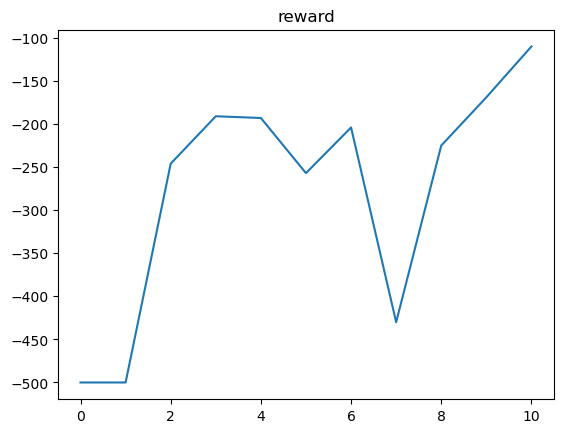

In [12]:
# 使用Matplotlib绘制奖励值的曲线图
plt.plot(return_list)
plt.title("reward")
plt.show()

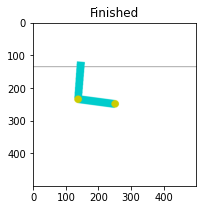

In [14]:
# 重置环境，开始新的一轮游戏
observation, _ = env.reset()
# 创建GymHelper对象来辅助显示
gym_helper = GymHelper(env, figsize = (3, 3))
episode_rewards = []

# 开始游戏
for i in range(1000):
    # 渲染环境，title为当前步骤数
    gym_helper.render(title = str(i))
    
    # 找到当前状态下的最优动作
    action = mbpo.agent.choose_action(observation)
    # 执行action，获取新的信息
    observation, reward, terminated, truncated, info = env.step(action)
    episode_rewards.append(reward)
    
    # 如果游戏结束，则结束当前循环
    if terminated or truncated:
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()